In [1]:
from pynq import Overlay, allocate
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt

# Load the overlay

In [2]:
overlay = Overlay("./conv_512/conv_512.bit")
conv_ip = overlay.conv_0
AP_CTRL = 0x00
IMAGE_IN_DATA = 0x10  # Address where the input data should be written
IMAGE_OUT_DATA = 0x1c  # Address where the output data will be read from
KERNEL_BASE = 0x30  # Base address for the kernel

# Load the kernel

In [19]:
example_kernel = np.array([[-1, -1, -1],
                           [-1, 8, -1],
                           [-1, -1, -1]], dtype=np.int8).flatten()

In [20]:
def pack_kernel(kernel):
    packed_kernel = []
    for i in range(0, len(kernel), 4):
        word = 0
        for j in range(4):
            if i + j < len(kernel):
                word |= (int(kernel[i + j]) & 0xFF) << (8 * j)
        packed_kernel.append(word)
    return packed_kernel

In [21]:
packed_kernel = pack_kernel(example_kernel)
for i, word in enumerate(packed_kernel):
    conv_ip.write(KERNEL_BASE + 4 * i, word)

# Load the test image and resize if necessary

In [22]:
test_image_path = './test_512.jpg'
original_image = Image.open(test_image_path)
original_image = original_image.convert('L')  # Convert to grayscale

# Ensure the image dimensions match the input size for the IP

In [23]:
Width, Height = original_image.size
if Width != 512 or Height != 512:
    original_image = original_image.resize((512, 512))

# Allocate buffers for the input and output images

In [24]:
input_buffer  = allocate(shape=(512, 512), dtype=np.uint8)
output_buffer = allocate(shape=(512, 512), dtype=np.uint8)

# Copy the image data into the input buffer and transfer to the FPGA

In [25]:
input_buffer[:] = np.array(original_image)

In [26]:
print(input_buffer)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [27]:
input_buffer.sync_to_device()

# Define run_kernel function:

In [28]:
def run_kernel():
     # Set the physical addresses for the input and output data in the IP
    conv_ip.write(IMAGE_IN_DATA, input_buffer.physical_address)
    conv_ip.write(IMAGE_OUT_DATA, output_buffer.physical_address)
    # Start the IP core
    conv_ip.write(AP_CTRL, 0x01)
    
    # Wait for the convolution to finish
    while (conv_ip.read(AP_CTRL) & 0x2) == 0:
        pass

# Measure the time taken for the convolution operation

In [29]:
start_time = time.time()
run_kernel()
end_time = time.time()

# Calculate the elapsed time

In [30]:
elapsed_time = end_time - start_time
print(f"Convolution time: {elapsed_time:.6f} seconds")

Convolution time: 0.093687 seconds


# Transfer the output buffer back from the FPGA and create an image from it

In [31]:
output_buffer.sync_from_device()

In [32]:
convolved_image = Image.fromarray(output_buffer.astype('uint8'))

# Display the original and convolved images

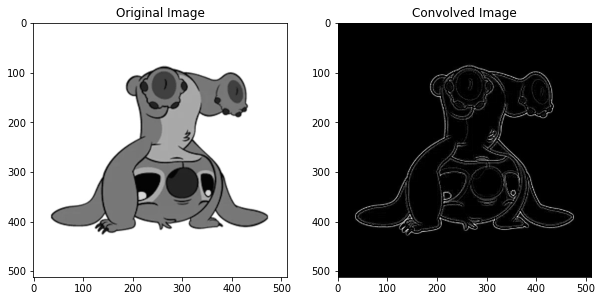

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image, cmap='gray')
ax[0].title.set_text('Original Image')
ax[1].imshow(convolved_image, cmap='gray')
ax[1].title.set_text('Convolved Image')
plt.show()

# Free the allocated buffers

In [34]:
input_buffer.close()
output_buffer.close()